# Kernel Density Estimation for outlier detection

# Motivation

A common assumption in pattern recognition is that all classes are known. This assumption does not hold in many real-world applications, where classes which are not currently part of the model do exist. 

In the context of kernel densities, we hypothesize that a novel class is one in which samples in the feature space occur in regions of low density relative to each known class, but in high density relative to the overall population.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.neighbors.kde import KernelDensity

%matplotlib inline

Load sample glass data.

In [2]:
data = pd.read_csv("../data/glass.csv", index_col=False,names=["class"] + list(range(8))) 
data_features = [x for x in range(8)]
classes = np.unique(data["class"])
data.head()

,class,0,1,2,3,4,5,6,7
0,1,-0.134323,-0.124812,1.000000,-0.495327,-0.296429,-0.980676,-0.382900,-1
1,1,-0.432839,-0.049624,0.603564,-0.333333,0.042858,-0.845411,-0.553903,-1
2,1,-0.558380,-0.157895,0.581292,-0.221184,0.135713,-0.874396,-0.563197,-1
3,1,-0.428443,-0.254135,0.643653,-0.376947,0.000000,-0.816425,-0.481413,-1
4,1,-0.449511,-0.236090,0.612472,-0.408100,0.167857,-0.822866,-0.509294,-1


Read SDSS data, preprocessed by colour indices and reddenning correction

In [3]:
# data = pd.read_hdf('../data/sdss.h5', 'sdss')
# data.head()

Use the same features as reported in Alasdair Tran's Honours thesis 2015.

In [4]:
# target_col = 'class'
# data_features = ['psfMag_r_w14', 'psf_u_g_w14', 'psf_g_r_w14', 'psf_r_i_w14',
#                 'psf_i_z_w14', 'petroMag_r_w14', 'petro_u_g_w14', 'petro_g_r_w14',
#                 'petro_r_i_w14', 'petro_i_z_w14', 'petroRad_r']

### Bandwidth Selection

We use the median of the pairwise Euclidean distances as a heuristic to determine bandwidth size.

In [5]:
#h = 1/np.sqrt(0.02) # Bandwidth coming from Alasdair's SVM experiments

def percentile_pairwise_distance(X, Y=None):
    if Y is None: Y = X
    distances = metrics.pairwise_distances(X, Y)
    return np.percentile(distances, 20)

h = percentile_pairwise_distance(data[data_features].values)
print("Bandwidth:", h)

Bandwidth: 0.363524969507


(**TODO**) Define the training, validation, and test sets, and select appropriate Gaussian kernel bandwidth. Use sklearn's [grid search](http://scikit-learn.org/stable/auto_examples/neighbors/plot_digits_kde_sampling.html) to find a good bandwidth.

In [6]:
num_data = len(data)
idx_all = np.random.permutation(num_data)
num_train = int(np.floor(0.7*num_data))
idx_train = idx_all[:num_train]
idx_test = idx_all[num_train:]

Estimate a kernel density estimator on the training set

In [7]:
kde = KernelDensity(kernel='gaussian', bandwidth=h, rtol=1e-5)
Xtrain = data[data_features].ix[idx_train] 
kde.fit(Xtrain)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.36352496950745972,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=1e-05)

Use the fitted density to estimate the log density for all items in the test set

In [8]:
Xtest = data[data_features].ix[idx_test]
pred = kde.score_samples(Xtest)

Choose an appropriate threshold for identifying outliers

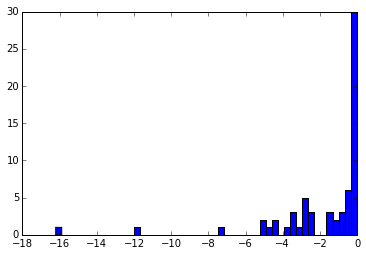

In [9]:
_ = plt.hist(pred, bins=50)

In [10]:
idx_sort = np.argsort(pred)
pred[idx_sort[:10]]

array([-16.21298768, -11.97811452,  -7.19716116,  -5.01309666,
        -4.9343533 ,  -4.58470706,  -4.55138562,  -4.28446769,
        -3.67064493,  -3.55356224])

Identify the outliers in the dataset. (**TODO**) Export or visualise appropriately for getting feedback from the astronomers.

In [11]:
idx_outlier = idx_test[np.where(pred < -7)]
data.ix[idx_outlier]

,class,0,1,2,3,4,5,6,7
186,7,-0.365227,0.079699,0.452116,0.202492,-0.485714,-0.529791,-0.933085,0.034921
184,6,-1.000000,1.000000,-1.000000,-0.968847,1.000000,-1.000000,-0.773234,-1.000000
163,5,-0.649687,-0.013534,0.193764,1.000000,-0.971428,-0.458937,-0.918216,0.396825


Calculate class-specific densities

In [12]:
densities = {}
for cl in classes:
    Xtrain_cl = Xtrain[data["class"]==cl]
    densities[cl] = KernelDensity(kernel='gaussian', bandwidth=h, rtol=1e-5)
    densities[cl].fit(Xtrain_cl)

/Users/cong/anaconda3/lib/python3.4/site-packages/pandas/core/frame.py:1997: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


## Discussion

* We need to check for outliers on the whole dataset. This can be done by cross validation (an outer loop). However, we also need to check that the various estimated densities from each split are similar.
* We have not used the labels. Consider the difference between regions of low density in the unlabelled case and regions of low density when using only data from a single class.
* The original downloaded SDSS data also contains uncertainties about the magnitude, which can be used to cross check whether outliers are noisy measurements.
* A set of sanity checks are usually used for cleaning up the data before analysis. Cross check that the outliers mostly fail the sanity checks

In [13]:
class_pred = {}
for cl in classes:
    class_pred[cl] = densities[cl].score_samples(Xtest)
    class_pred[cl] -= pred

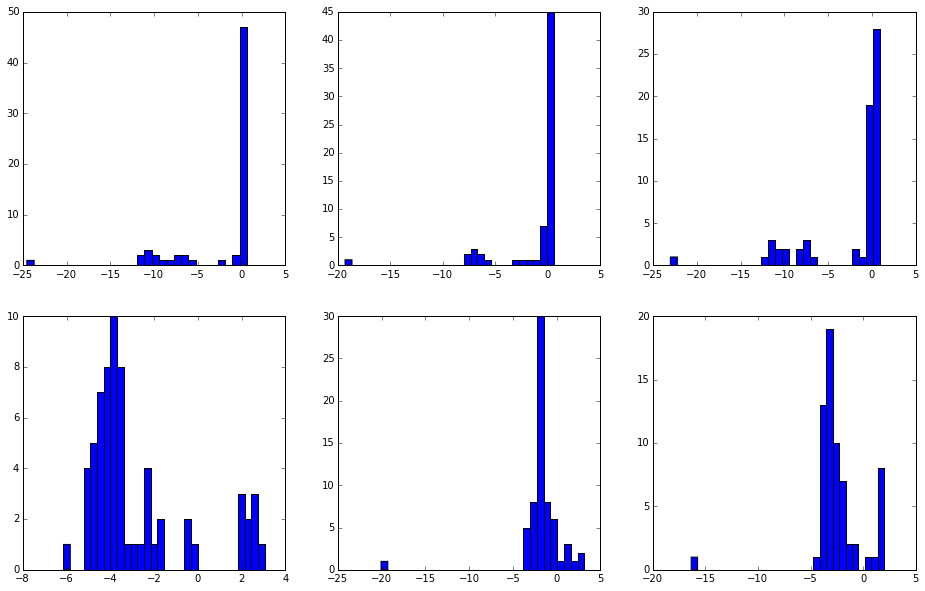

In [14]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(231)
_ = ax.hist(class_pred[1], 30)
ax = fig.add_subplot(232)
_ = ax.hist(class_pred[2], 30)
ax = fig.add_subplot(233)
_ = ax.hist(class_pred[3], 30)
ax = fig.add_subplot(234)
_ = ax.hist(class_pred[5], 30)
ax = fig.add_subplot(235)
_ = ax.hist(class_pred[6], 30)
ax = fig.add_subplot(236)
_ = ax.hist(class_pred[7], 30)